## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


# 1.Camera Calibration

## 1. 1compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os.path
#%matplotlib qt
%matplotlib inline

In [2]:
#nx=9
#ny=6

#images=glob.glob('../camera_cal/calibration*.jpg')
### Define the camera_calibration function
def undistort(img,mtx,dist,verbose= False):
    ##calculate the distortion coffecient and calibration matrix use cv2.calibrateCamera
    #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    ##undistort input images
    undist=cv2.undistort(img, mtx, dist, None, mtx)
    
    if verbose:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(undist)
        ax2.set_title('Undistorted Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
        
    return undist
    

In [3]:
def cam_calibration(image_dir,nx,ny,verbose=False):
    
    # Arrays to store object points and image points from all the images
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    # Step through the list and search for chessboard corners
    
    
    # make a list of calibration images
    images= glob.glob(os.path.join(image_dir,"calibration*.jpg"))
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)       
        if verbose:
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            #cv2.imshow('img',img)
            plt.imshow(img)
            #cv2.waitKey(500)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret,mtx,dist,rvecs,tvecs


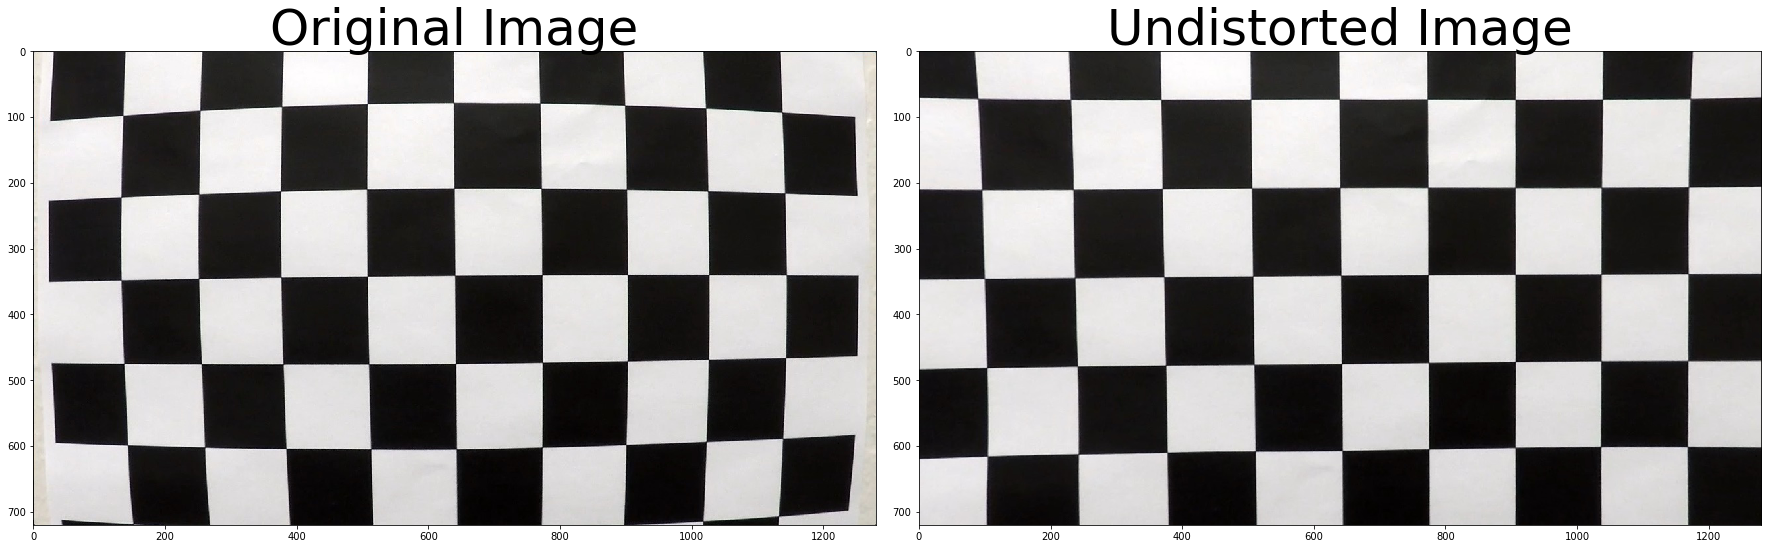

In [4]:
### Test with one raw image under folder ../camera_cal
ret,mtx,dist,rvecs,tvecs= cam_calibration(image_dir="../camera_cal/",nx=9,ny=6)

test_image= mpimg.imread("../camera_cal/calibration1.jpg")
#print("image before undistort")
#plt.imshow(test_image)
#undistorted_test_image=undistort(test_image,mtx,dist)
undistorted_test_image=undistort(test_image,mtx,dist,verbose= True)


# 2. Pipeline

## 2.1 Image Binariztion

## 2.1.1 Apply a distortion correction to raw images.

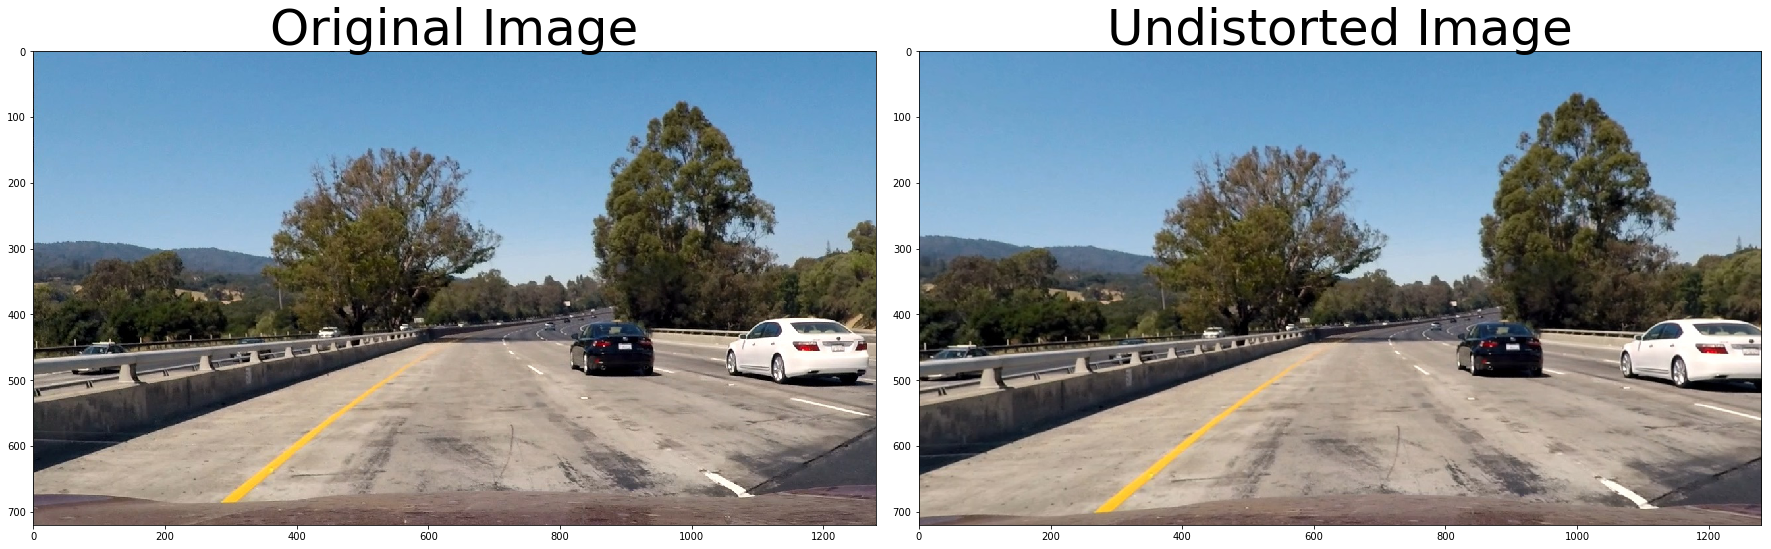

In [5]:
test_img= mpimg.imread("../test_images/test1.jpg")


undistorted_img=undistort(test_img,mtx,dist,verbose= True)
difference= undistorted_img-test_img




Text(0.5,1,'difference')

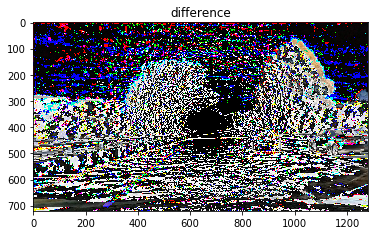

In [6]:
plt.imshow(difference)
plt.title("difference")

## 2.1.2 Use color transforms, gradients, etc., to create a thresholded binary image.

##  sobel gradient mask

In [7]:
def abs_sobel_thresh(img, orient='x', thresh=[0,255]):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray_img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=="x":
        sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
    elif orient=="y":
        sobelx= cv2.Sobel(gray_img, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobelx)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output=np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output
    
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    ##Use cv2.COLOR_RGB2GRAY if you've read in an image using mpimg.imread().
    ##Use cv2.COLOR_BGR2GRAY if you've read in an image using cv2.imread().
     # 1) Convert to grayscale
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
     # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
     # 3) Calculate the magnitude 
    abs_sobelxy=np.sqrt(sobelx**2+sobely**2)
      # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    abs_sobelxy = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
     # 5) Create a binary mask where mag thresholds are met
    binary_output=np.zeros_like(abs_sobelxy)
    binary_output[(abs_sobelxy >= mag_thresh[0]) & (abs_sobelxy <= mag_thresh[1])] = 1
     # 6) Return this mask as binary_output image
    return binary_output


def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
      # 1) Convert to grayscale
    gray_img= cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
     # 2) Take the gradient in x and y separately
    sobelx=cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
    sobely=cv2.Sobel(gray_img, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the x and y gradients
    sobelx=np.absolute(sobelx)
    sobely=np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    grad=np.arctan2(sobely,sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output=np.zeros_like(grad)
    binary_output[(grad >= thresh[0]) & (grad <= thresh[1])] = 1
    return binary_output


In [8]:
def compute_sobel_thresh(image,ksize,verbose=False):
    gradx = abs_sobel_thresh(image, orient='x', thresh=(25, 255))
    grady = abs_sobel_thresh(image, orient='y', thresh=(25, 255))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 2.0))
    
    if verbose:
        f, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(gradx,cmap="gray")
        ax1.set_title('Gradx', fontsize=50)
        ax2.imshow(grady,cmap="gray")
        ax2.set_title('Grady', fontsize=50)
        ax3.imshow(mag_binary,cmap="gray")
        ax3.set_title('mag_binary', fontsize=50)
        ax4.imshow(dir_binary,cmap="gray")
        ax4.set_title('dir_binary', fontsize=50)
        
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return gradx, grady, mag_binary,dir_binary





In [10]:
def combined_sobel_gradient(grady,mag_binary):
    return cv2.bitwise_or(grady, mag_binary)

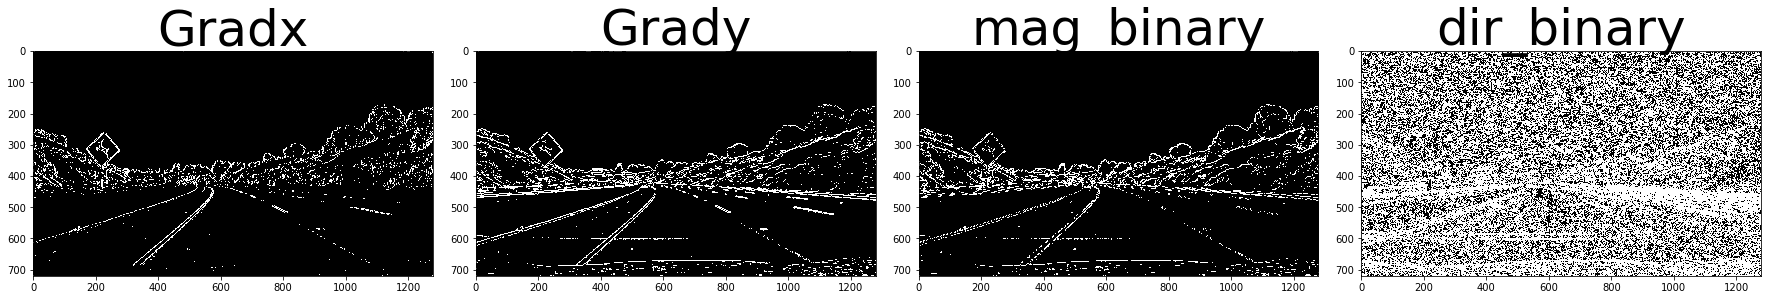

In [11]:
test_img= mpimg.imread("../test_images/test2.jpg")
gradx,grady,mag_binary,dir_binary=compute_sobel_thresh(test_img,ksize=3,verbose= True)

In [12]:
combined_sobel_mask=combined_sobel_gradient(grady,mag_binary)

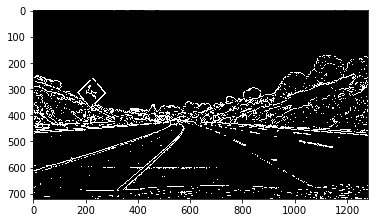

In [13]:
plt.imshow(combined_sobel_mask,cmap="gray")

##  Color mask (Compare HLS, YUV and HSV respectively)

In [14]:
def color_space_visualize(img,convert,name):
    convert_color= cv2.cvtColor(img,convert)
    plt.figure()
    
    for i in range(3):
        plt.subplot(1,3,i+1)
        img_channel= convert_color[:,:,i]
        plt.imshow(255*(img_channel/np.max(img_channel)), cmap='gray')
        plt.axis('off')
        
    plt.title(name)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
        
    

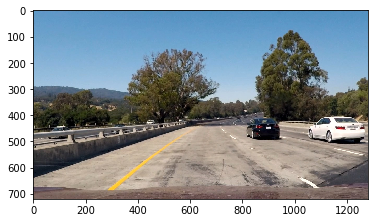

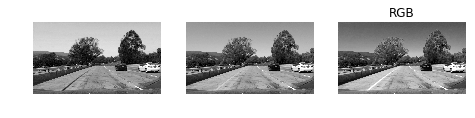

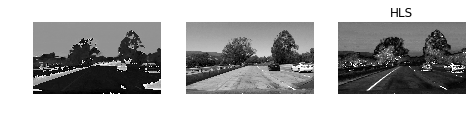

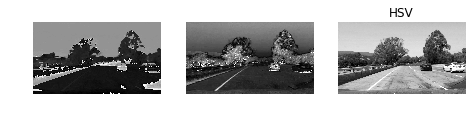

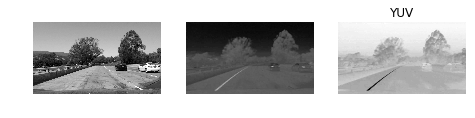

In [15]:
test_img= mpimg.imread("../test_images/test1.jpg")
plt.figure()
plt.imshow(test_img)

rgb_visualize=color_space_visualize(test_img,cv2.COLOR_BGR2RGB,"RGB")
hls_visualize=color_space_visualize(test_img,cv2.COLOR_RGB2HLS,"HLS")
hsv_visualize=color_space_visualize(test_img,cv2.COLOR_RGB2HSV,"HSV")
yuv_visualize=color_space_visualize(test_img,cv2.COLOR_RGB2YUV,"YUV")




In [16]:
def mask_binarization(img,thresh):
    binary_output=np.zeros_like(img)
    binary[(img > thresh[0]) & (img <= thresh[1])] = 1
    
    return binary_output
    

In [17]:
def extract_yellow(image,thresh,verbose=False):##[170,255]
    ### s_channel of HLS is the most important for yellow extraction.
    hls_image=cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    s_channel=hls_image[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    if verbose:
        plt.figure()
        plt.imshow(s_binary,cmap="gray")
        plt.title("extract_yellow_binary")
        
    return s_binary
    
    #yellow_lower = np.array([15,50,170])
    #yellow_upper = np.array([25,200,255])
    #return cv2.inRange(img_hls, yellow_lower, yellow_upper) // 255
    

In [18]:
def extract_yellow_update(image,verbose=False):
    hls_image=cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    yellow_lower = np.array([15,50,100])
    yellow_upper = np.array([25,200,255])
    
    extract_yellow_binary=cv2.inRange(hls_image, yellow_lower, yellow_upper) // 255
    if verbose:
        plt.figure()
        plt.imshow(extract_yellow_binary,cmap="gray")
        plt.title("extract_yellow_binary")
        
    return extract_yellow_binary

In [19]:
def extract_white(image,verbose=False):
    hls_image=cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    white_lower = np.array([0,  200, 0])
    white_upper = np.array([255,255, 255])
    
    extract_white_binary=cv2.inRange(hls_image, white_lower, white_upper) // 255
    if verbose:
        plt.figure()
        plt.imshow(extract_white_binary,cmap="gray")
        plt.title("extract_white_binary")
        
    return extract_white_binary


Text(0.5,1,'combined_color_mask')

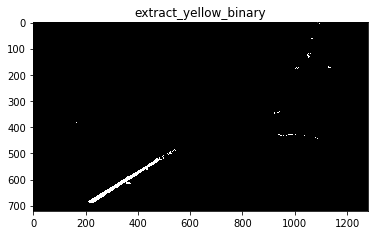

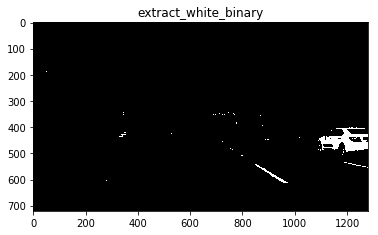

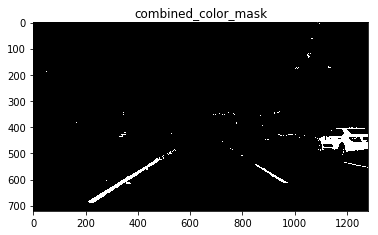

In [20]:
test_img= mpimg.imread("../test_images/test5.jpg")
#yellow_binary=extract_yellow(test_img,thresh=[170,255],verbose= True)
yellow_binary=extract_yellow_update(test_img,verbose= True)
white_binary=extract_white(test_img,verbose= True)
color_mask = cv2.bitwise_or(yellow_binary, white_binary)
plt.figure()
plt.imshow(color_mask,cmap="gray")
plt.title("combined_color_mask")



In [35]:
def combined_mask(img):
    yellow_binary=extract_yellow_update(img)
    white_binary=extract_white(img)
    color_mask = cv2.bitwise_or(yellow_binary, white_binary)
    
    output_mask=cv2.bitwise_or(gradx,color_mask)
    plt.imshow(output_mask,cmap="gray")
    return output_mask
    

In [31]:
test_img= mpimg.imread("../test_images/test5.jpg")

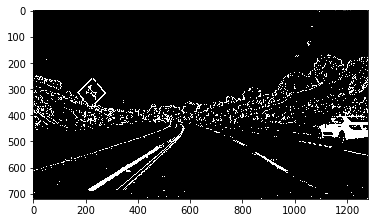

In [36]:
output_mask=combined_mask(test_img)

## Final Combination Mask

In [21]:
def mask_to_rgb(img):
    return 255 * np.dstack((img, img, img))

In [22]:
test_img= mpimg.imread("../test_images/test5.jpg")


In [23]:
def threshold_from_lecture(img,sxbinary_thresh,s_thresh,verbose=False):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    #threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sxbinary_thresh[0]) & (scaled_sobel <= sxbinary_thresh[1])] = 1
    
    
    # Threshold color channel
    #s_thresh_min = 170
    #s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    if verbose:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('Stacked thresholds')
        ax1.imshow(color_binary)

        ax2.set_title('Combined S channel and gradient thresholds')
        ax2.imshow(combined_binary, cmap='gray')
  
    return combined_binary
  

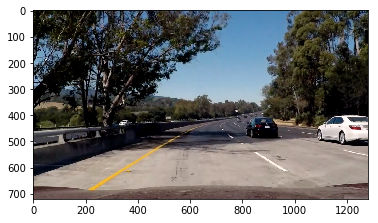

In [24]:
test_img= mpimg.imread("../test_images/test5.jpg")
plt.imshow(test_img)

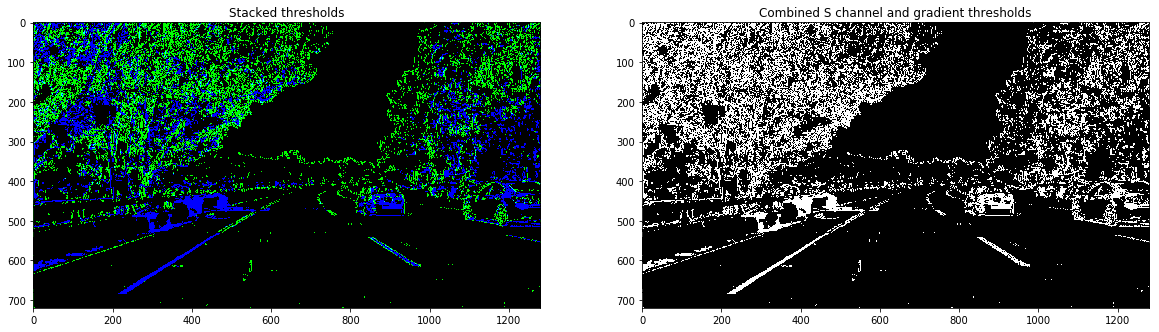

In [25]:
test_image_binary=threshold_from_lecture(test_img,sxbinary_thresh=[20,100],s_thresh=[170,255],verbose= True)

In [26]:
def final_mask_combination(img,verbose=False):###yellow_thresh[170,255]
    yellow_binary=extract_yellow_update(img,verbose= False)
    white_binary=extract_white(img,verbose= False)  
    color_mask = cv2.bitwise_or(yellow_binary, white_binary)
    
    ##then compute the sobel gradient thresh.
    gradx,grady,mag_binary,dir_binary=compute_sobel_thresh(img,ksize=3,verbose=False)
    combined_sobel_mask=combined_sobel_gradient(gradx,mag_binary)
    Final_mask=cv2.bitwise_or(color_mask,gradx)
    Final_mask=mask_to_rgb(Final_mask)
    Final_mask= cv2.bitwise_or(color_mask,combined_sobel_mask)
    
    if verbose:
        plt.imshow(Final_mask,cmap="gray")
    return Final_mask
    
    
    

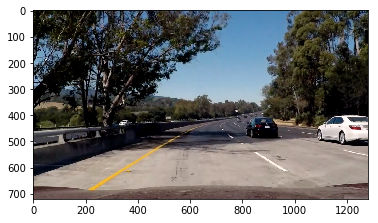

In [27]:
test_img= mpimg.imread("../test_images/test5.jpg")
plt.figure()
plt.imshow(test_img)

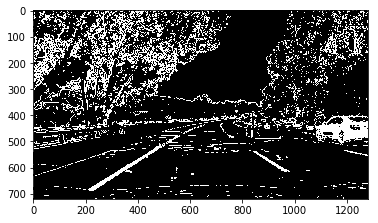

In [28]:
final_mask=final_mask_combination(test_img,verbose= True)
final_mask_com=mask_to_rgb(final_mask)
plt.imshow(final_mask_com,cmap="gray")


## 2.2 Apply a perspective transform to rectify binary image ("birds-eye view").

In [28]:
print(test_img.shape)

(720, 1280, 3)


In [29]:
def perspect_trans(img,verbose=False):
    ####apply perspective transform to get the birdview of image
    img_size=(img.shape[1],img.shape[0])
    x1=205
    x2=1100
    y_rough=460
    offset= 100
    

    src=((x1,img.shape[0]),(x2,img.shape[0]),(700,y_rough),(585,y_rough))

    dst=((x1+offset,img.shape[0]),(x2-offset,img.shape[0]),(x2-offset,0),(x1+offset,0))
    
    M = cv2.getPerspectiveTransform(np.float32(src), np.float32(dst))
    Minv = cv2.getPerspectiveTransform(np.float32(src), np.float32(dst))
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    
    if verbose:
        #image_visual=img.copy()
        for i in range(4):
            img=cv2.line(img,src[i],src[(i+1)%4], color=[255,0,0],thickness=4)
            warped=cv2.line(warped,dst[i],dst[(i+1)%4], color=[255,0,0],thickness=4)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(warped)
        ax2.set_title('BirdEye Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return warped,M,Minv    

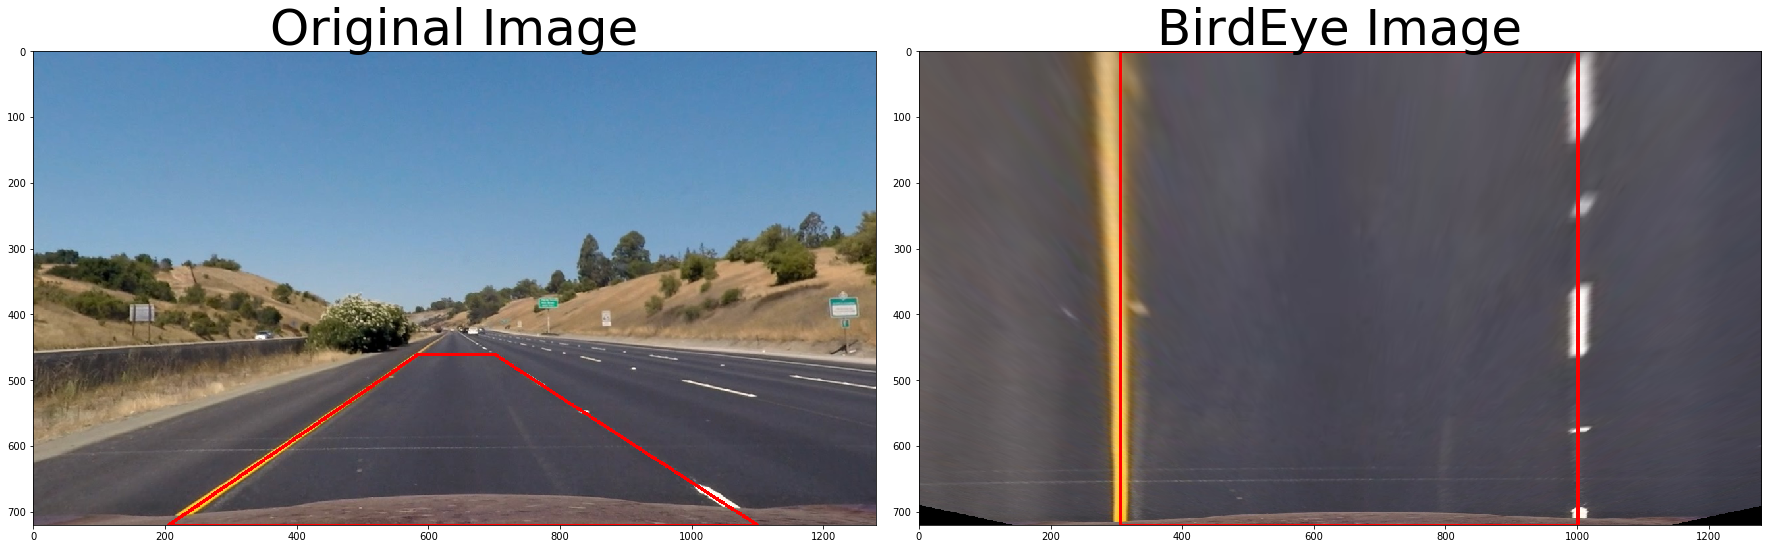

In [30]:
##define roi region
test_img= mpimg.imread("../test_images/straight_lines1.jpg")
#plt.imshow(test_img)
undistorted_test=undistort(test_img,mtx,dist)
warped,M,Minv=perspect_trans(undistorted_test,verbose=True)



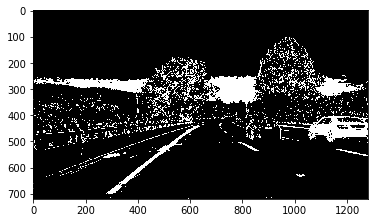

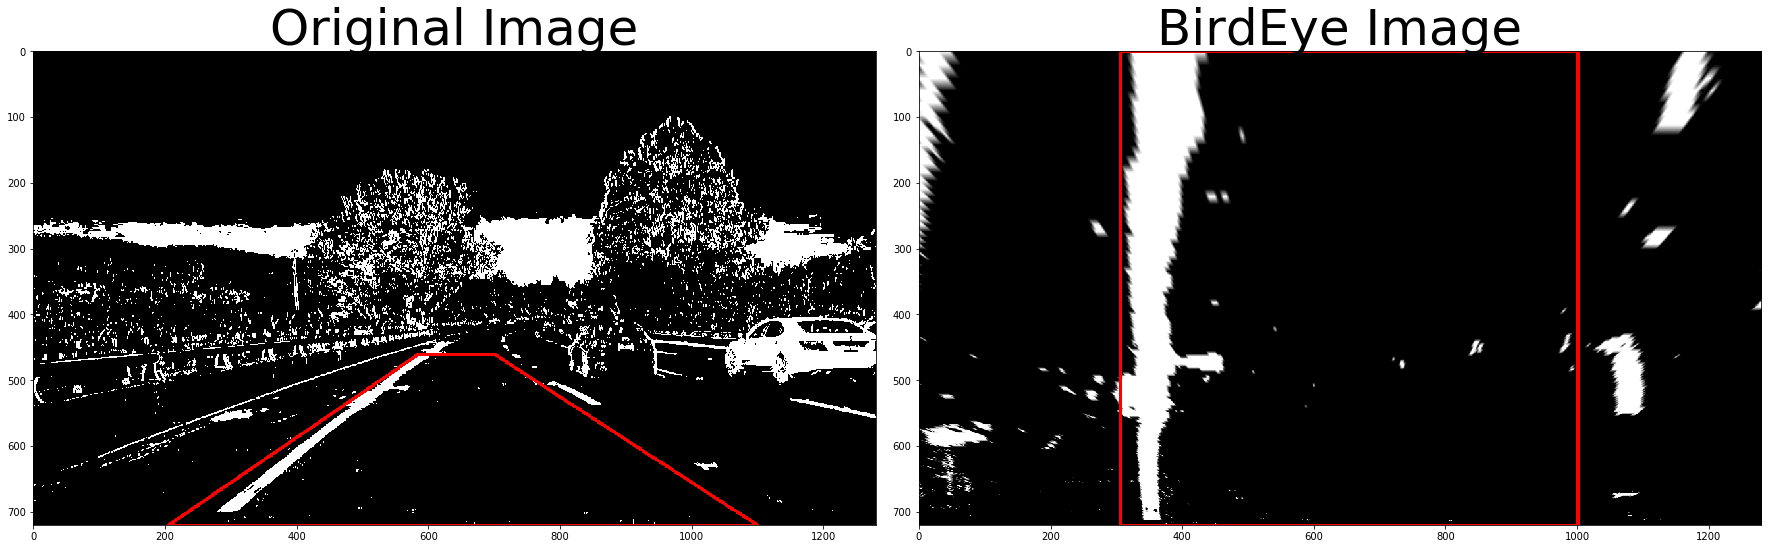

In [32]:
test_img= mpimg.imread("../test_images/test4.jpg")
test_img=undistort(test_img,mtx,dist)
final_mask=final_mask_combination(test_img,verbose=True)
#final_mask_com=mask_to_rgb(final_mask)
#plt.imshow(final_mask_com,cmap="gray")
x,y,z=perspect_trans(final_mask,verbose=True)


### Combine Threshold and Perspective Transform

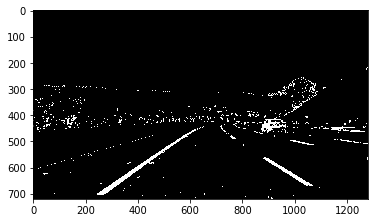

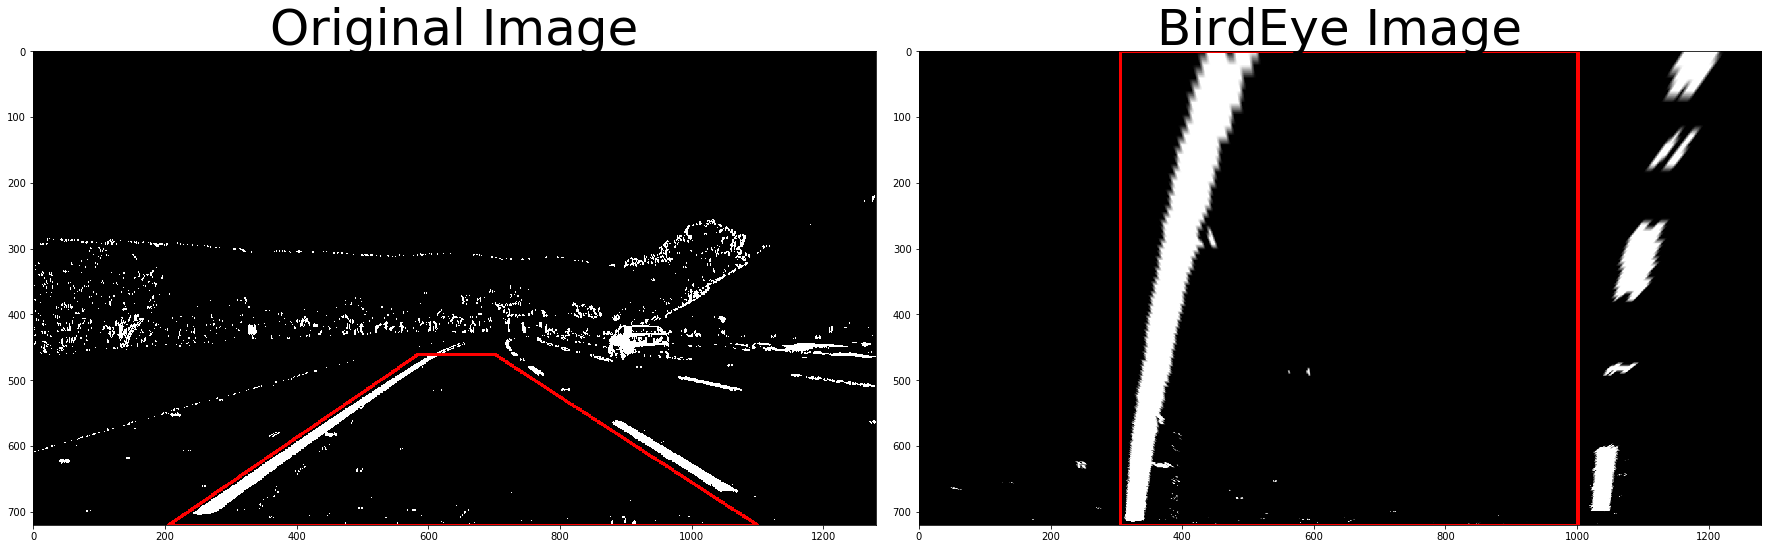

In [31]:
test_img= mpimg.imread("../test_images/test3.jpg")
test_img=undistort(test_img,mtx,dist)
final_mask=final_mask_combination(test_img,verbose=True)
#final_mask_com=mask_to_rgb(final_mask)
#plt.imshow(final_mask_com,cmap="gray")
x,y,z=perspect_trans(final_mask,verbose=True)

## Detect lane pixels and fit to find the lane boundary.

In [109]:
test_img= mpimg.imread("../test_images/test3.jpg")
test_img=undistort(test_img,mtx,dist)
binary_warped_img=final_mask_combination(test_img)


In [110]:
binary_warped_img,M,Minv=perspect_trans(binary_warped_img)

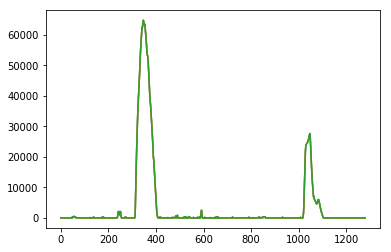

In [111]:
histogram= np.sum(binary_warped_img[binary_warped_img.shape[0]//2:,:],axis=0)
plt.plot(histogram)

In [149]:
binary_warped= mpimg.imread("../test_images/test1.jpg")
binary_warped=undistort(binary_warped,mtx,dist)
binary_warped=final_mask_combination(binary_warped)
binary_warped,M,Minv=perspect_trans(binary_warped)


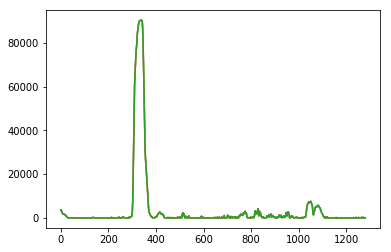

In [150]:
histogram= np.sum(binary_warped[binary_warped.shape[0]//2:,:],axis=0)
plt.plot(histogram)

In [151]:
import numpy as np
import cv2
import matplotlib.pyplot as pl

out_img = binary_warped.copy()

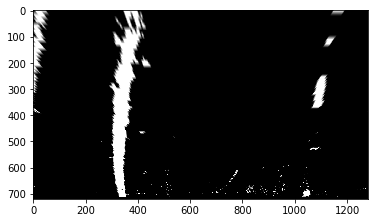

In [152]:
plt.imshow(out_img)

In [156]:
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
print(midpoint,leftx_base,rightx_base)
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
print(nonzero,nonzerox,nonzeroy)
leftx_current = leftx_base
rightx_current = rightx_base
print(leftx_current,rightx_current)
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = 720 - (window+1)*window_height
    #win_y_high = binary_warped.shape[0] - window*window_height
    win_y_high = 720 - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0),2)
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0),2)
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


640 1005 1870
(array([  0,   0,   0, ..., 719, 719, 719]), array([  3,   3,   3, ..., 538, 538, 538]), array([0, 1, 2, ..., 0, 1, 2])) [  3   3   3 ... 538 538 538] [  0   0   0 ... 719 719 719]
1005 1870


In [161]:
print(right_lane_inds)

[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]


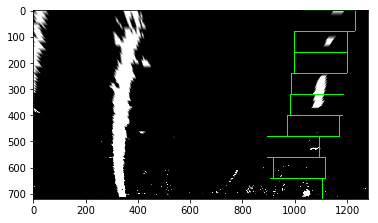

In [157]:
plt.imshow(out_img)

In [123]:

for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0),2)
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0),2)
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)





TypeError: expected non-empty vector for x